In [1]:
# COMP20008_Project_2 
# Created on 17th September 2019
# Written by Chia-Wei Cheng, chiaweic (1025192), JiaHern Lee, jiahern (997562), KaiYuan Zheng, kzzhe (1024904)

import pandas as pd
import numpy as np
import sklearn
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import math,random
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
import re
from difflib import SequenceMatcher


K_NN_5 = 5
K_NN_10 = 10




In [2]:
#similarity calculation function
def similar(a,b):
    return SequenceMatcher(None, a, b).ratio()

#build a function to find matching pair by blocking method
def find_pair (limit,thrhold,bsize):
    i = 0
    
    #create an empty dataframe to store the matched pairs
    pair_found = pd.DataFrame(columns = ["idAmazon","idGoogleBase"])
    
    #each loop will generate a block for amazon and google, and add the matched pairs to pair_found
    while i<limit:
        #generate blocks with same blocking key
        condition_a = ((amazon["price"]>=i) & (amazon["price"]<=i+bsize))
        condition_g = ((google["price"]>=i) & (google["price"]<=i+bsize))
        block_a = amazon[condition_a]
        block_g = google[condition_g]
        
        #create two empty lists to store the index values
        pair_index_a = []
        pair_index_g = []
        
        #match the records from different blocks by attributes "title", "name"
        for record1 in block_a["title"]:
            for record2 in block_g["name"]:
                score = similar(record1,record2)
                if score > thrhold:
                    pair_index_a.append(block_a[block_a["title"]==record1].idAmazon.values[0])
                    pair_index_g.append(block_g[block_g["name"]==record2].id.values[0])
        
        #format the matched pairs into dataframe and append to the empty dataframe
        pairs = pd.DataFrame({'idAmazon':pair_index_a,'idGoogleBase':pair_index_g})
        pair_found = pair_found.append(pairs, ignore_index=True)
        i+=bsize
    return pair_found

In [3]:
# Naive data linkage

#Read in datasets
amazon_s = pd.read_csv("amazon_small.csv")
google_s = pd.read_csv('google_small.csv')
gt_s = pd.read_csv('amazon_google_truth_small.csv')

#create two empty lists to store the index values
pair_index_A = []
pair_index_G = []
#link the records from different datasets by attributes 'title', 'name'
for record1 in amazon_s["title"]:
    for record2 in google_s["name"]:
        score = similar(record1,record2)
        #after several attempts, decide to use 0.65 as the threshold to obtain similar size of pairs with ground truth
        if score > 0.54:
            pair_index_A.append(amazon_s[amazon_s["title"]==record1].idAmazon.values[0])
            pair_index_G.append(google_s[google_s["name"]==record2].idGoogleBase.values[0])

pairs = pd.DataFrame({'idAmazon':pair_index_A,'idGoogleBase':pair_index_G})
#merge the ground truth with our matched pairs to get true possitive pairs
tp_pair = pd.merge(pairs, gt_s, how='inner', on=['idAmazon','idGoogleBase'])

true_match = gt_s.shape[0]
tp = tp_pair.shape[0]
fn = gt_s.shape[0]-tp
fp = pairs.shape[0]-tp

#evaluate the perfomance of linkage by recall and precision
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print ("True Matches:",true_match)
print ("Correctly Matched:",tp)
print ("Recall:",recall)
print ("Precision:",precision)

True Matches: 130
Correctly Matched: 96
Recall: 0.7384615384615385
Precision: 0.7218045112781954


In [4]:
# Part 1 Na¨ıve data linkage without blocking

#2. The linkage method we applied is based on the amazon_small(title) and google_small(name). This is due to there are no
#    Null value in those attributes which may increase the accuracy of the similarity comparison. For similarity function,
#    there are roughly three types of similarity function: Edit distance based, Token-based and Sequence-based(Pattern Search).   
#    Among three of them, Sequence-based has the highest result. By applying Sequence-based similarity function, 
#    SequenceMatcher by difflib. The theory is based on Gestalt Pattern Matching, finding the longest common substring 
#    plus recursively the number of matching characters in the non-matching regions on both sides of the LCS. The more matching,
#    the higher similarity score will be. The threshold(0.54) is set depends on the amount of rows of ground truth dataset. 
#    When threshold higher, the output row lesser.By using this function, it allows us to indicate the long strings in both 
#    of the attributes precisely. Overall, the performance's results are pretty presentable, recall(0.74) and precision(0.72).    

In [5]:
# Blocking method


# It will roughly take you 3 mins

#Read in different datasets
google = pd.read_csv("google.csv")
amazon = pd.read_csv("amazon.csv")
gt = pd.read_csv("amazon_google_truth.csv")

#Data Cleaning google

#convert price in google dataset, gbp pound sterling into aud 
for row in google.index:
    if "gbp" in google.loc[row,"price"]:
        price = google.loc[row,"price"]
        google.loc[row,"price"] = 1.83*int(re.findall("\d+", price)[0])

google['price'] = pd.to_numeric(google['price'], errors = 'coerce')

#Data Cleaning amazon

amazon.sort_values("price")
amazon['price'] = pd.to_numeric(amazon['price'], errors = 'coerce')

#name the result as pair01
#use 10e5 as limit since it is bigger than all price values in either amazon or google
#after several attempts, decide to use 0.65 as the threshold to obtain similar size of pairs with ground truth
pairs = find_pair(10e5,0.65,50)

#merge the ground truth with our matched pairs to get true possitive pairs
TP_pairs = pd.merge(pairs,gt,how="inner",on=["idAmazon","idGoogleBase"])

TP = TP_pairs.shape[0]
FP = pairs.shape[0]-TP
FN = gt.shape[0]-TP
TN = amazon.shape[0]*google.shape[0]-TP
n = TP + FP + FN + TN

PC = TP/(TP+FN)
RR = 1 - (TP+FP)/n

print ("True Matches:",gt.shape[0])
print ("Correctly Matched:",TP)
print ("Pair Completeness:",PC)
print ("Reduction Ratio:",RR)

True Matches: 1300
Correctly Matched: 511
Pair Completeness: 0.3930769230769231
Reduction Ratio: 0.9996937705843798


In [6]:
# Part 2 Blocking for efficient data linkage
#For our blocking method, we choose to divide the blocks base on the price of the both datasets. 
#We allocate the rows according to different price values, and the ranges have the same gap. By applying this criteria, 
#we distribute the records into blocks in which the records have approxiamate price values. However, the pair completeness
#is not very high and we get a high value of reduction ratio. We suppose there are two reasons for this result. First reason
#is that the blocks we divide do not have the same size. Because it is not garanteed that same range of price will have same 
#amount of records. Secondly, we only take use of one attribute when calculating similarity scores, which will decrease 
#our matching accuracy. In addition to these aspects, the time consumed when blocking is applied is a third of the time 
#using naive data linkage. Therefore, the blocking method boosts the data linkage process. 

In [7]:
# Part 2 Pre-processing

# Original dataset

# Open yeast file
original = pd.read_csv("all_yeast.csv")

# A list contains the name of each feature
feature_list = original.keys()[1:9]

med_mean = ["median", "mean"]
result = pd.DataFrame(index = feature_list, columns = med_mean)
result["median"] = [original[i].median() for i in feature_list]
result["mean"] = [original[i].mean() for i in feature_list]

result.style.format("{:.2f}")

,median,mean
mcg,0.48,0.50
gvh,0.49,0.50
alm,0.51,0.51
mit,0.22,0.26
erl,0.50,0.51
pox,0.00,0.01
vac,0.51,0.50
nuc,0.22,0.28


In [8]:
original.head()

,Sample,mcg,gvh,alm,mit,erl,pox,vac,nuc,Class
0,1,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,non-CYT
1,2,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,non-CYT
2,3,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,non-CYT
3,4,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,non-CYT
4,5,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,non-CYT


In [9]:
# Part 2 Pre-processing 

# Impute missing value (Mean imputation)

# Open yeast file 
mean_yeast = pd.read_csv("all_yeast.csv")

# A list contains the name of each feature
feature_list = mean_yeast.keys()[1:9]

# A list contains the original value of mean of each feature
feature_mean = [mean_yeast[i].mean() for i in feature_list]

# Apply mean imputation
for i in range(len(feature_list)):
    mean_yeast[feature_list[i]] = mean_yeast[feature_list[i]].fillna(feature_mean[i])
    
# Construct a DataFrame for the result
result_feature = ["min", "median", "max", "mean", "standard deviation"]
result = pd.DataFrame(index = feature_list, columns = result_feature)
result["min"] = [mean_yeast[i].min() for i in feature_list]
result["median"] = [mean_yeast[i].median() for i in feature_list]
result["max"] = [mean_yeast[i].max() for i in feature_list]
result["mean"] = [mean_yeast[i].mean() for i in feature_list]
result["standard deviation"] = [mean_yeast[i].std() for i in feature_list]

result.style.format("{:.2f}")

,min,median,max,mean,standard deviation
mcg,0.11,0.50,1.00,0.50,0.13
gvh,0.13,0.49,1.00,0.50,0.12
alm,0.21,0.51,7.50,0.51,0.20
mit,0.00,0.23,3.00,0.26,0.15
erl,0.50,0.50,3.50,0.51,0.09
pox,0.00,0.00,0.83,0.01,0.08
vac,0.00,0.51,6.00,0.50,0.15
nuc,0.00,0.22,4.50,0.28,0.15


In [10]:
# Part 2 Pre-processing

# Impute missing value (median imputation)

# Open yeast file
median_yeast = pd.read_csv("all_yeast.csv")

# A list contains the name of each feature
feature_list = median_yeast.keys()[1:9]

# A list contains the original value of median of each feature
feature_median = [mean_yeast[i].median() for i in feature_list]

# Apply median imputation
for i in range(len(feature_list)):
    median_yeast[feature_list[i]] = median_yeast[feature_list[i]].fillna(feature_median[i])

# Construct a DataFrame for the result
result_feature = ["min", "median", "max", "mean", "standard deviation"]
result = pd.DataFrame(index = feature_list, columns = result_feature)
result["min"] = [median_yeast[i].min() for i in feature_list]
result["median"] = [median_yeast[i].median() for i in feature_list]
result["max"] = [median_yeast[i].max() for i in feature_list]
result["mean"] = [median_yeast[i].mean() for i in feature_list]
result["standard deviation"] = [median_yeast[i].std() for i in feature_list]

result.style.format("{:.2f}")

,min,median,max,mean,standard deviation
mcg,0.11,0.50,1.00,0.50,0.13
gvh,0.13,0.49,1.00,0.50,0.12
alm,0.21,0.51,7.50,0.51,0.20
mit,0.00,0.23,3.00,0.26,0.15
erl,0.50,0.50,3.50,0.51,0.09
pox,0.00,0.00,0.83,0.01,0.08
vac,0.00,0.51,6.00,0.50,0.15
nuc,0.00,0.22,4.50,0.28,0.15


In [11]:
# Part 2 Pre-processing

# Evaluation (Mean imputation and median imputation)

# Mean imputation does not change the mean value overall, while median imputation might affect the mean and the 
#  distribution of the dataset if the difference between the mean and median is huge.  Therefore, I suggest that 
#  it would be better to use mean imputation rather than median imputation if the dataset is widely spread.
#  However, for all_yeast dataset, it can be seen that the median and the mean are rather close.  Thus, I 
#  believe that both methods are suitable for this datase

In [12]:
# Part 2 Pre-processing

# Scale the features (Mean centering)

# Create a feature list
feature_list = mean_yeast.keys()[1:9]

# Create a copy of median_yeast
mean_centred_yeast = median_yeast.copy()

# Substract mean from every value in every feature
for feature in feature_list:
    mean_centred_yeast[feature] = [float(i) - median_yeast[feature].mean() for i in mean_centred_yeast[feature]]
    

result_feature = ["min", "median", "max", "mean", "standard deviation"]
result = pd.DataFrame(index = feature_list, columns = result_feature)
result["min"] = [mean_centred_yeast[i].min() for i in feature_list]
result["median"] = [mean_centred_yeast[i].median() for i in feature_list]
result["max"] = [mean_centred_yeast[i].max() for i in feature_list]
result["mean"] = [mean_centred_yeast[i].mean() for i in feature_list]
result["standard deviation"] = [mean_centred_yeast[i].std() for i in feature_list]

result.style.format("{:.2f}")

,min,median,max,mean,standard deviation
mcg,-0.39,0.00,0.50,0.00,0.13
gvh,-0.37,-0.01,0.50,0.00,0.12
alm,-0.30,0.00,7.00,0.00,0.20
mit,-0.26,-0.03,2.74,-0.00,0.15
erl,-0.01,-0.01,2.99,0.00,0.09
pox,-0.01,-0.01,0.82,0.00,0.08
vac,-0.50,0.01,5.50,0.00,0.15
nuc,-0.28,-0.06,4.22,-0.00,0.15


In [13]:
# Part 2 Pre-processing

# Scale the features (Standardisation)

# Create a feature list
feature_list = mean_yeast.keys()[1:9]

# Create a copy of median_yeast
std_yeast = median_yeast.copy()

# Substract mean and divide by standard deviation from every value in every feature
for feature in feature_list:
    std_yeast[feature] = [(float(i) - median_yeast[feature].mean())/median_yeast[feature].std() for i in std_yeast[feature]]
        
        
result_feature = ["min", "median", "max", "mean", "standard deviation"]
result = pd.DataFrame(index = feature_list, columns = result_feature)
result["min"] = [std_yeast[i].min() for i in feature_list]
result["median"] = [std_yeast[i].median() for i in feature_list]
result["max"] = [std_yeast[i].max() for i in feature_list]
result["mean"] = [std_yeast[i].mean() for i in feature_list]
result["standard deviation"] = [std_yeast[i].std() for i in feature_list]

result.style.format("{:.2f}")

,min,median,max,mean,standard deviation
mcg,-2.96,0.00,3.81,0.00,1.00
gvh,-3.03,-0.08,4.10,0.00,1.00
alm,-1.48,0.02,35.01,0.00,1.00
mit,-1.74,-0.21,18.19,-0.00,1.00
erl,-0.07,-0.07,32.69,0.00,1.00
pox,-0.10,-0.10,10.87,-0.00,1.00
vac,-3.28,0.04,35.82,0.00,1.00
nuc,-1.82,-0.37,27.73,-0.00,1.00


In [14]:
# Part 2 Pre-processing

# Evaluation (Scale the features)

# Mean centering can be treated as the first step of standardisation as standardisation simply just divide every 
#  value by standard deviation after mean centering.  After performing Mean centering, the entire spectrum moves
#  toward the 0 without changing the relationship between each point and will end up with 0 as the mean value.
# After applying standardisation, the standard deviation of every feature become 1 which solves the issue of 
#  having data measured on different scales.

In [15]:
# Part 2 Comparing Classification Algorithms (Using mean centred yeast)

# Create a feature list
feature_list = mean_yeast.keys()[1:9]

# Get the 8 features with its numerical data
mean_centred_data = mean_centred_yeast[feature_list].astype(float)

# Get the class labels
classlabel = mean_centred_yeast['Class']

# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(mean_centred_data,classlabel, train_size=0.66, test_size=0.34, random_state=42)

# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(X_train, y_train)
knn_10.fit(X_train, y_train)

# K = 5 and K = 10
y_pred_5 = knn_5.predict(X_test)
y_pred_10 = knn_10.predict(X_test)

# Print the result
print('K-NN (K = 5):', accuracy_score(y_test, y_pred_5))
print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

# Construct the decision tree
dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=3)
dt.fit(X_train, y_train)

y_pred=dt.predict(X_test)
print('Decision tree:', accuracy_score(y_test, y_pred))

K-NN (K = 5): 0.7029702970297029
K-NN (K = 10): 0.695049504950495
Decision tree: 0.6831683168316832


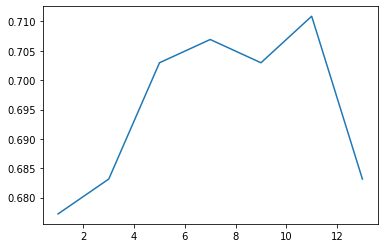

In [16]:
# Plot accuracy score vs k_values (from 1 to 15)

k_values = range(1, 15, 2)

score_list = []
for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train) 
    y_pred = knn.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(k_values, score_list)
plt.show()

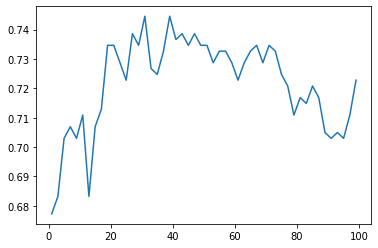

In [17]:
# Plot accuracy score vs k_values (from 1 to 100)

k_values = range(1, 100, 2)

score_list = []
for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train) 
    y_pred = knn.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(k_values, score_list)
plt.show()

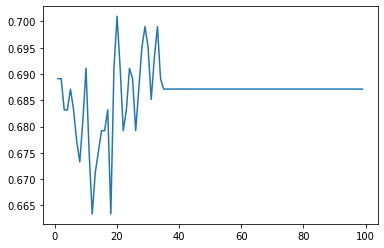

In [18]:
# Plot accuracy score vs depth_values (from 1 to 100)

depth_values = range(1, 100, 1)

score_list = []
for depth in depth_values:
    dt = DecisionTreeClassifier(criterion="entropy", random_state = 1, max_depth = depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(depth_values, score_list)
plt.show()

In [19]:
# Part 2 Comparing Classification Algorithms (Using median imputed yeast)

# Create a feature list
feature_list = median_yeast.keys()[1:9]

# Get the 8 features with its numerical data
median_data = median_yeast[feature_list].astype(float)

# Get the class labels
classlabel = median_yeast['Class']

# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(median_data,classlabel, train_size = 0.66, test_size = 0.34, random_state = 42)

# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(X_train, y_train)
knn_10.fit(X_train, y_train)

# K = 5 and K = 10
y_pred_5 = knn_5.predict(X_test)
y_pred_10 = knn_10.predict(X_test)

# Print the result
print('K-NN (K = 5):', accuracy_score(y_test, y_pred_5))
print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

# Construct the decision tree
dt = DecisionTreeClassifier(criterion = "entropy",random_state = 1, max_depth = 3)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Decision tree:', accuracy_score(y_test, y_pred))

K-NN (K = 5): 0.7029702970297029
K-NN (K = 10): 0.695049504950495
Decision tree: 0.6831683168316832


In [20]:
# Part 2 Comparing Classification Algorithms (Using median imputed yeast)

# Create a feature list
feature_list = median_yeast.keys()[1:9]

# Get the 8 features with its numerical data
median_data = median_yeast[feature_list].astype(float)

# Get the class labels
classlabel = median_yeast['Class']

# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(median_data,classlabel, train_size = 0.66, test_size = 0.34, random_state = 42)

# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(X_train, y_train)
knn_10.fit(X_train, y_train)

# K = 5 and K = 10
y_pred_5 = knn_5.predict(X_test)
y_pred_10 = knn_10.predict(X_test)

# Print the result
print('K-NN (K = 5):', accuracy_score(y_test, y_pred_5))
print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

# Construct the decision tree
dt = DecisionTreeClassifier(criterion = "entropy",random_state = 1, max_depth = 3)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Decision tree:', accuracy_score(y_test, y_pred))

K-NN (K = 5): 0.7029702970297029
K-NN (K = 10): 0.695049504950495
Decision tree: 0.6831683168316832


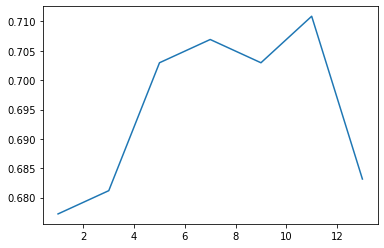

In [21]:
k_values = range(1, 15, 2)

score_list = []
for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train) 
    y_pred = knn.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(k_values, score_list)
plt.show()

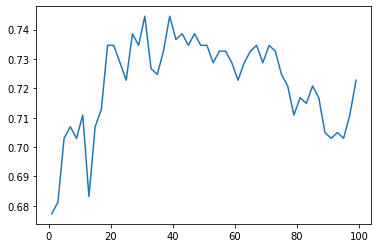

In [22]:
# Plot accuracy score vs k_values (from 1 to 100)

k_values = range(1, 100, 2)

score_list = []
for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train) 
    y_pred = knn.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(k_values, score_list)
plt.show()

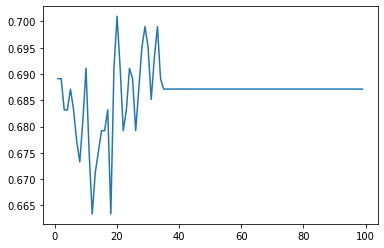

In [23]:
# Plot accuracy score vs depth_values (from 1 to 100)

depth_values = range(1, 100, 1)

score_list = []
for depth in depth_values:
    dt = DecisionTreeClassifier(criterion="entropy", random_state = 1, max_depth = depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score_list.append(accuracy_score(y_test, y_pred))
    

plt.plot(depth_values, score_list)
plt.show()

In [24]:
# Part2 Comparing Classification Algorithms 

# Discussion

# Both mean centred and median imputed dataset produce the same graph and accuracy scores.  It can be seen that
#  K-NN K = 5 has the highest accuracy score, while decision tree algorithms produce the lowest score.  The highest
#  accuracy that decision tree can achieve is around 0.7 when the depth is around 20, while the higest accuracy 
#  that K-NN can achieve is around 0.75 when K is around 30.

In [25]:
# A function for Feature Engineering part

def feature_reduction(data, selection_list):
    
    ''' Take a 2D array which contains a set of N features (the original features plus generated features) 
        and return a 2D array after feature selection based on the selection_list '''
    reduced_data = []
    for i in data:
        temp = []
        for j in selection_list:
            temp.append(i[j])
        reduced_data.append(temp)
    return reduced_data

def feature_generator(data):
    feature_list = data.keys()
    for i in range(len(feature_list)-1):
        for j in range(i, len(feature_list)):
            if i == j:
                continue
            data["{} * {}".format(feature_list[i], feature_list[j])] = data[feature_list[i]] * data[feature_list[j]]
    return data




def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

In [26]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer

NUM_FEATURES = 5

# Part 2 Feature Engineering

# Interaction term pairs (Using mean centred_yeast) (Multiplication Only)

# Get the 8 features
feature_list = mean_centred_yeast.keys()[1:9]

# Generate interaction term pairs (All possible pairs on multiplication)
mul_mean_centred_data = feature_generator(mean_centred_data.copy())

    

# Discretise all numerical values
discrete_data = KBinsDiscretizer(n_bins = 2, encode = 'ordinal', strategy = 'uniform')
discrete_data.fit(mul_mean_centred_data)
discrete_mul_data = discrete_data.transform(mul_mean_centred_data)

# Class label
classlabel = mean_centred_yeast["Class"]


# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(discrete_mul_data,classlabel, train_size=0.66, test_size=0.34, random_state=42)


# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Calculate the mutual information between each column and the class label
mutual_info_mul = mutual_info_classif(X_train, y_train, discrete_features = True)

# Create a dataframe 
score = pd.DataFrame({"feature": mul_mean_centred_data.keys(),"score":mutual_info_mul}).sort_values(by = "score", ascending = False)
selection_list = list(score.iloc[:NUM_FEATURES,:].index)


reduced_X_train = feature_reduction(X_train, selection_list)
reduced_X_test = feature_reduction(X_test, selection_list)


# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(reduced_X_train, y_train)
knn_10.fit(reduced_X_train, y_train)


y_pred_5 = knn_5.predict(reduced_X_test)
y_pred_10 = knn_10.predict(reduced_X_test)
print('K-NN Accuracy Score:', accuracy_score(y_test, y_pred_5))
#print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

K-NN Accuracy Score: 0.691089108910891


In [27]:
mul_mean_centred_data.head().style.format("{:.2f}")

,mcg,gvh,alm,mit,erl,pox,vac,nuc,mcg * gvh,mcg * alm,mcg * mit,mcg * erl,mcg * pox,mcg * vac,mcg * nuc,gvh * alm,gvh * mit,gvh * erl,gvh * pox,gvh * vac,gvh * nuc,alm * mit,alm * erl,alm * pox,alm * vac,alm * nuc,mit * erl,mit * pox,mit * vac,mit * nuc,erl * pox,erl * vac,erl * nuc,pox * vac,pox * nuc,vac * nuc
0,0.08,0.11,-0.04,-0.13,-0.01,-0.01,-0.02,-0.06,0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.07,0.17,-0.03,0.01,-0.01,-0.01,0.03,-0.06,-0.01,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.01,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
2,0.14,0.12,-0.02,-0.11,-0.01,-0.01,0.03,-0.06,0.02,-0.00,-0.02,-0.00,-0.00,0.00,-0.01,-0.00,-0.01,-0.00,-0.00,0.00,-0.01,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00
3,0.08,-0.06,0.06,-0.13,-0.01,-0.01,0.04,-0.06,-0.00,0.01,-0.01,-0.00,-0.00,0.00,-0.00,-0.00,0.01,0.00,0.00,-0.00,0.00,-0.01,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00
4,-0.08,-0.06,-0.03,0.28,-0.01,-0.01,-0.02,-0.06,0.00,0.00,-0.02,0.00,0.00,0.00,0.00,0.00,-0.02,0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
# Part 2 Feature Engineering

# Clustering labels (Using mean centred data)

mean_centred_cluster = mean_centred_data.copy()

clusters = KMeans(n_clusters = 5).fit(mean_centred_cluster)

cluster_classlabel = clusters.labels_

# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(mean_centred_cluster,cluster_classlabel, train_size=0.66, test_size=0.34, random_state=42)

# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(reduced_X_train, y_train)
knn_10.fit(reduced_X_train, y_train)


y_pred_5 = knn_5.predict(reduced_X_test)
y_pred_10 = knn_10.predict(reduced_X_test)
print('K-NN (K = 5):', accuracy_score(y_test, y_pred_5))
print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

K-NN (K = 5): 0.8138613861386138
K-NN (K = 10): 0.8138613861386138


In [29]:
# Part 2 Feature Engineering 

# Feature generation and selection with cluster labels (Using mean centred data)
mul_cluster_data = feature_generator(mean_centred_data.copy())


clusters = KMeans(n_clusters = 5).fit(mean_centred_cluster)

cluster_classlabel = clusters.labels_

# Randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(mul_cluster_data,cluster_classlabel, train_size=0.66, test_size=0.34, random_state=42)

# Normalise the data to have 0 mean and unit variance using the library functions.  
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


# Calculate the mutual information between each column and the class label
mutual_info_mul = mutual_info_classif(X_train, y_train, discrete_features = True)

# Create a dataframe 
score = pd.DataFrame({"feature": mul_mean_centred_data.keys(),"score":mutual_info_mul}).sort_values(by = "score", ascending = False)
selection_list = list(score.iloc[:NUM_FEATURES,:].index)


reduced_X_train = feature_reduction(X_train, selection_list)
reduced_X_test = feature_reduction(X_test, selection_list)


# Appy K-NN algorithm
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_5)
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = K_NN_10)
knn_5.fit(reduced_X_train, y_train)
knn_10.fit(reduced_X_train, y_train)


y_pred_5 = knn_5.predict(reduced_X_test)
y_pred_10 = knn_10.predict(reduced_X_test)
print('K-NN (K = 5):', accuracy_score(y_test, y_pred_5))
print('K-NN (K = 10):', accuracy_score(y_test, y_pred_10))

K-NN (K = 5): 0.7247524752475247
K-NN (K = 10): 0.7346534653465346


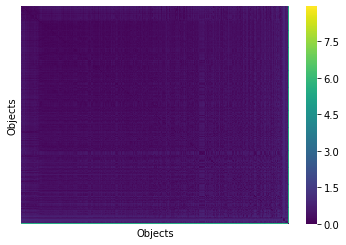

In [30]:
RV, C, I = VAT(mean_centred_data)
x=sns.heatmap(RV,cmap='viridis',xticklabels=False,yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.show()

In [31]:
# Part 2 Feature Engineering Discussion

# Since both mean centred and median imputed dataset produce rather similar results, we only present the mean
#  centred part.

# Interaction term pairs

# Since f1/f2 might have the situations that f2 = 0, We only consider all possible pairs of multiplication.
# I choose 5 as the number of features selection as the accuracy score nearly remains the same when the value 
#  is larger than 5.  Eventhough 1 produce a similar score, I believe that having only the highest correlated 
#  column being selected might result in a overfitting situation.  Besides, Every column has rather low 
#  mutual information with the class, therefore, having only one column to predict the result might not be a 
#  good prediction.

# Feature generation and selection

# Applying feature generation and selection do not boost the accuracy score even if we change 
#  the number of bins during the discretisation stage.  This is might due to the fact that most of the points 
#  are very close to each other.  Thus, generating more points by multiplication or division might not be 
#  helpful for the prediction


# Feature generation with clustering labels 

# The accuracy score is 1 when k = 1 and the score starts decreasing when k is increased
# By plotting the heap map, it can be seen that there is only a huge cluster.  Since it is meaningless to 
#  have k = 1, we claim that using K-means algorithm is not a suitable solution for this case.
# As a result, using resulting cluster labels as the values for the class does not boost the accuracy score.
# What is more, it does not provide any useful information